In [ ]:
!mkdir -p data/potato_disease_dataset/PlantVillage/PlantVillage

In [ ]:
!mkdir -p data/potato_disease_dataset/PotatoPlants

In [ ]:
#!unzip PlantVillage.zip
#!unrar x PotatoPlants.rar

In [ ]:
!mv ./PlantVillage/* ./data/potato_disease_dataset/PlantVillage/PlantVillage

In [ ]:
#!mv ./Potato___Early_blight ./data/potato_disease_dataset/PotatoPlants
#!mv ./Potato___healthy ./data/potato_disease_dataset/PotatoPlants
!mv ./Potato___Late_blight ./data/potato_disease_dataset/PotatoPlants

In [ ]:
!ls ./data/potato_disease_dataset/PotatoPlants

Potato___Early_blight  Potato___healthy  Potato___Late_blight


In [ ]:
import torch, torchvision, os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_dir = "./data/potato_disease_dataset"
train_dir = "PlantVillage/PlantVillage"
test_dir = "PotatoPlants"

# TRANSFORMACION DE DATOS
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # IMAGENET
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# DATASETS
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, train_dir), transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, test_dir), transform=test_transform)

# CLASES
class_names = train_dataset.classes

# DATASET TRAIN Y TEST
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# CREACION DE DATALOADERS - DATASET PARA PYTORCH
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
print(f"Train Dataset: {len(train_dataset)}")
print(f"Validation Dataset: {len(val_dataset)}")
print(f"Test Dataset: {len(test_dataset)}")
print(f"Clases: {class_names}")

Train Dataset: 1721
Validation Dataset: 431
Test Dataset: 2152
Clases: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


<Axes: title={'center': "['Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight']"}>

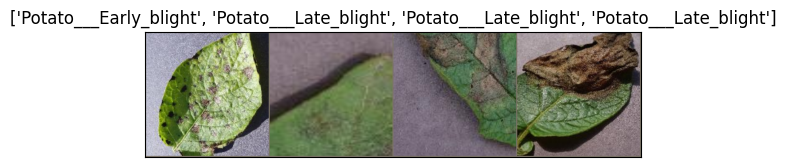

In [ ]:
def image_show(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)
    return ax


# MUESTRA DE IMAGENES
inputs, classes = next(iter(train_loader))

# IMAGENES EN GRILLA
out = torchvision.utils.make_grid(inputs[:4])

# VISUALIZACION
image_show(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
# DEFINICION DEL MODELO Y VARIABLES DEL MODELO
model = torchvision.models.vgg19(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

# OBTENER LA CANTIDAD DE FEATURES DEL MODELO DE SALIDA
num_features = model.classifier[6].in_features

# REEMPLAZO DE LA CANTIDAD DE FEAUTRES DE SALIDA
model.classifier[6] = torch.nn.Linear(num_features, len(class_names))

# FUNCTION DE PERDIDA
criterion = torch.nn.CrossEntropyLoss()

# OPTIMIZADOR Y LEARNING RATE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 70.6MB/s]


In [ ]:
import time
from tempfile import TemporaryDirectory

def train(
    train_dataloader,
    val_dataloader,
    model,
    criterion,
    optimizer,
    lr_scheduler,
    epochs=25,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):

    model.to(device)
    train_size = len(train_dataloader.dataset)
    val_size = len(val_dataloader.dataset)
    since = time.time()

    best_acc = 0.0
    l_val = []
    l_train = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_dataloader
                size = train_size
            else:
                model.eval()
                dataloader = val_dataloader
                size = val_size

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # PARAMETRO DE GRADIENTES A ZERO
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # BACKWARD Y OPTIMIZACION
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                lr_scheduler.step()

            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size
            if phase == "train":
              l_train.append((f"{epoch_loss:.4f}", f"{epoch_acc:.4f}"))
            else:
              l_val.append((f"{epoch_loss:.4f}", f"{epoch_acc:.4f}"))
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # OBTENCION DEL MEJOR ESTDISTICA
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc

    time_elapsed = time.time() - since
    print(
        f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    print(f"Best val Acc: {best_acc:4f}")

    return model, l_val, l_train

In [ ]:
import random

def visualize_model(l_index, model, dataloader, class_names, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_images=8):
    was_training = model.training
    model.to(device).eval()

    all_images = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            all_images.extend(inputs)
            all_labels.extend(labels)

    # SI LA LISTA L_INDEX ESTA VACIA SE TOMARA IMAGENES ALEATORIAS
    total_images = len(all_images)
    if len(l_index) > 0:
      selected_indices = l_index
    else:
      selected_indices = random.sample(range(total_images), min(num_images, total_images))
    print(selected_indices)
    fig = plt.figure(figsize=(15, 3 * ((num_images + 3) // 4)))

    #ITERACION DE LA LISTA DE INDEXES PARA LA OBTENCIOS DE IMAGENES Y CLASES
    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            input_image = all_images[idx].unsqueeze(0).to(device)
            label = all_labels[idx].to(device)

            output = model(input_image)
            _, pred = torch.max(output, 1)

            ax = fig.add_subplot(((num_images + 3) // 4), 4, i + 1)
            ax.axis('off')
            ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred.item()]}")
            image_show(input_image.cpu().squeeze(0), ax=ax)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def plot_model_performance(model, test_loader, class_names, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # CALCULO DE METRICAS DEL MODELO EVALUADO
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print('Accuracy', accuracy)
    print('Precision', precision)
    print('Recall', recall)
    print('F1', f1)

    # MATRIX DE CONFUCION DEL MODELO EVALUADO
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de confusion')
    plt.xlabel('Prediccion')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
model_vgg, model_vgg_l_val, model_vgg_l_train = train(train_loader, val_loader, model, criterion, optimizer, exp_lr_scheduler, epochs=25)# 25

Epoch 1/25
----------
train Loss: 0.2484 Acc: 0.9030
val Loss: 0.1815 Acc: 0.9327
Epoch 2/25
----------
train Loss: 0.2370 Acc: 0.9076
val Loss: 0.2158 Acc: 0.9118
Epoch 3/25
----------
train Loss: 0.2379 Acc: 0.9088
val Loss: 0.1871 Acc: 0.9397
Epoch 4/25
----------
train Loss: 0.2250 Acc: 0.9140
val Loss: 0.1984 Acc: 0.9258
Epoch 5/25
----------
train Loss: 0.2377 Acc: 0.9059
val Loss: 0.2249 Acc: 0.9072
Epoch 6/25
----------
train Loss: 0.2337 Acc: 0.9105
val Loss: 0.2001 Acc: 0.9188
Epoch 7/25
----------
train Loss: 0.2350 Acc: 0.9169
val Loss: 0.1633 Acc: 0.9490
Epoch 8/25
----------
train Loss: 0.2343 Acc: 0.9088
val Loss: 0.2011 Acc: 0.9304
Epoch 9/25
----------
train Loss: 0.2151 Acc: 0.9181
val Loss: 0.1753 Acc: 0.9420
Epoch 10/25
----------
train Loss: 0.2134 Acc: 0.9227
val Loss: 0.1951 Acc: 0.9234
Epoch 11/25
----------
train Loss: 0.2280 Acc: 0.9123
val Loss: 0.1869 Acc: 0.9281
Epoch 12/25
----------
train Loss: 0.2211 Acc: 0.9198
val Loss: 0.1788 Acc: 0.9443
Epoch 13/25
-

[2050, 153, 1022, 267, 1297, 984, 1897, 781]


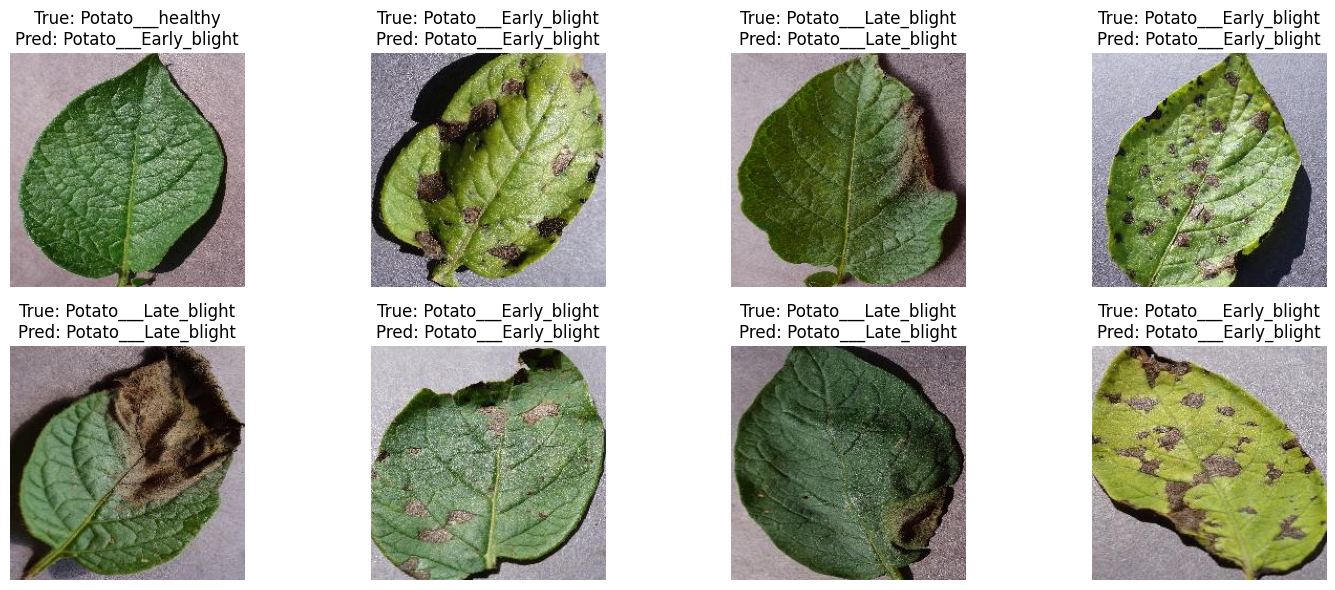

In [ ]:
visualize_model([2050, 153, 1022, 267, 1297, 984, 1897, 781], model_vgg, test_loader, class_names)
#[194, 1319, 1826, 1508, 1072, 430, 1927, 1609]

Accuracy 0.9530669144981413
Precision 0.9541177266981784
Recall 0.9530669144981413
F1 0.9531295022747072


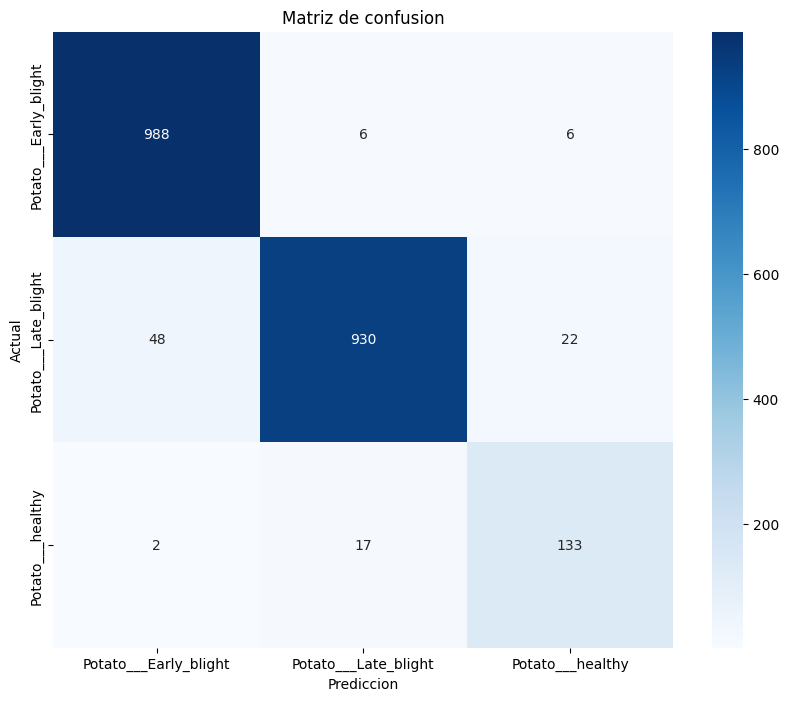

In [ ]:
plot_model_performance(model_vgg, test_loader, class_names)

In [ ]:
# DEFINICION DEL MODELO Y VARIABLES DEL MODELO
model_rs = torchvision.models.resnet18(weights="IMAGENET1K_V1")

for param in model_rs.parameters():
    param.requires_grad = False

# OBTENER LA CANTIDAD DE FEATURES DEL MODELO DE SALIDA
num_features = model_rs.fc.in_features

# REEMPLAZO DE LA CANTIDAD DE FEAUTRES DE SALIDA
model_rs.fc = torch.nn.Linear(num_features, len(class_names))

# FUNCTION DE PERDIDA
criterion = torch.nn.CrossEntropyLoss()

# OPTIMIZADOR Y LEARNING RATE
optimizer = torch.optim.Adam(model_rs.parameters(), lr=0.001)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.8MB/s]


In [ ]:
model_rsnet, model_rsnet_l_val, model_rsnet_l_train = train(train_loader, val_loader, model_rs, criterion, optimizer, exp_lr_scheduler, epochs=25)

Epoch 1/25
----------
train Loss: 0.7718 Acc: 0.6694
val Loss: 0.5693 Acc: 0.8469
Epoch 2/25
----------
train Loss: 0.4924 Acc: 0.8507
val Loss: 0.4124 Acc: 0.8608
Epoch 3/25
----------
train Loss: 0.3686 Acc: 0.8908
val Loss: 0.3332 Acc: 0.9049
Epoch 4/25
----------
train Loss: 0.2909 Acc: 0.9187
val Loss: 0.2606 Acc: 0.9304
Epoch 5/25
----------
train Loss: 0.2528 Acc: 0.9332
val Loss: 0.2325 Acc: 0.9466
Epoch 6/25
----------
train Loss: 0.2399 Acc: 0.9378
val Loss: 0.2062 Acc: 0.9582
Epoch 7/25
----------
train Loss: 0.2207 Acc: 0.9367
val Loss: 0.2106 Acc: 0.9374
Epoch 8/25
----------
train Loss: 0.1975 Acc: 0.9529
val Loss: 0.2123 Acc: 0.9374
Epoch 9/25
----------
train Loss: 0.1999 Acc: 0.9524
val Loss: 0.2007 Acc: 0.9350
Epoch 10/25
----------
train Loss: 0.2074 Acc: 0.9402
val Loss: 0.2036 Acc: 0.9420
Epoch 11/25
----------
train Loss: 0.2054 Acc: 0.9460
val Loss: 0.1909 Acc: 0.9559
Epoch 12/25
----------
train Loss: 0.1999 Acc: 0.9500
val Loss: 0.1936 Acc: 0.9513
Epoch 13/25
-

Accuracy 0.9679368029739777
Precision 0.9682525882492639
Recall 0.9679368029739777
F1 0.9678696721275247


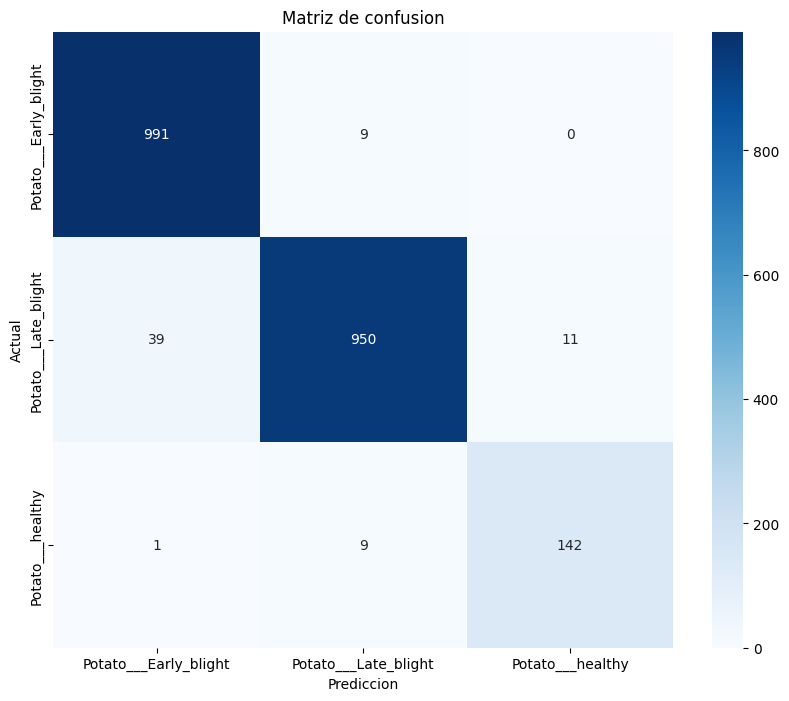

In [ ]:
plot_model_performance(model_rsnet, test_loader, class_names)

[2050, 153, 1022, 267, 1297, 984, 1897, 781]


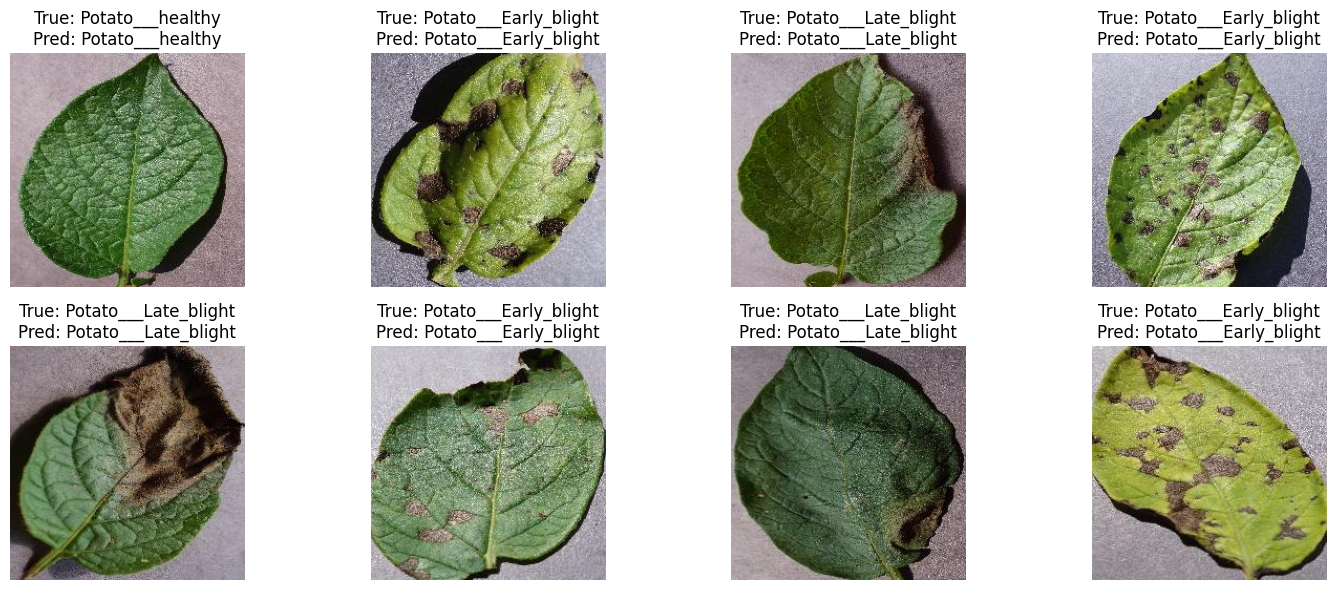

In [ ]:
visualize_model([2050, 153, 1022, 267, 1297, 984, 1897, 781], model_rsnet, test_loader, class_names)

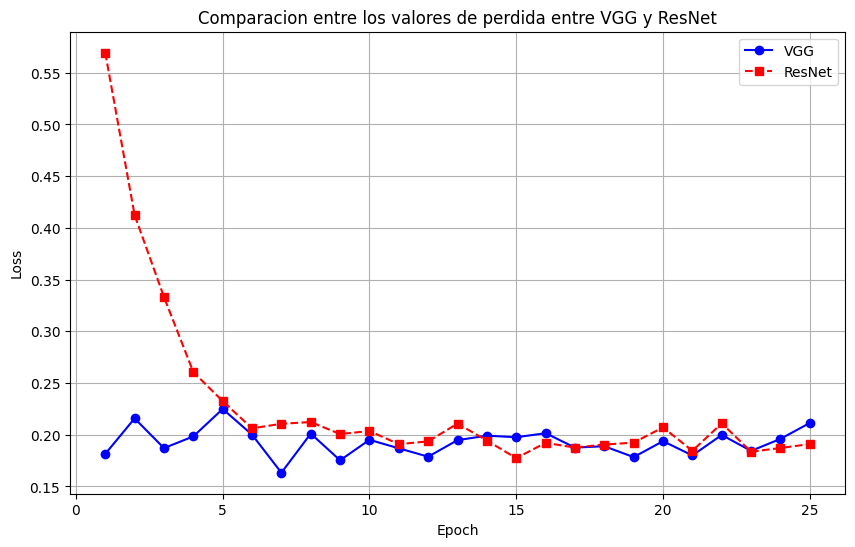

In [ ]:
vgg_a = [float(item[0]) for item in model_vgg_l_val]
rsnet_a = [float(item[0]) for item in model_rsnet_l_val]

epochs = range(1, len(vgg_a) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, vgg_a, marker='o', linestyle='-', color='b', label='VGG')
plt.plot(epochs, rsnet_a, marker='s', linestyle='--', color='r', label='ResNet')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparacion entre los valores de perdida entre VGG y ResNet')
plt.legend()

plt.grid(True)
plt.show()

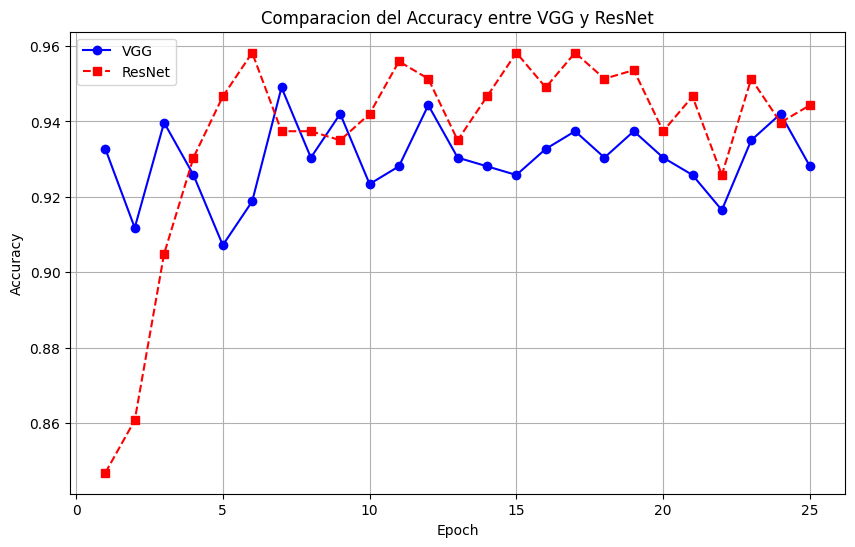

In [ ]:
vgg_b = [float(item[1]) for item in model_vgg_l_val]
rsnet_b = [float(item[1]) for item in model_rsnet_l_val]

epochs = range(1, len(vgg_b) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, vgg_b, marker='o', linestyle='-', color='b', label='VGG')
plt.plot(epochs, rsnet_b, marker='s', linestyle='--', color='r', label='ResNet')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparacion del Accuracy entre VGG y ResNet')
plt.legend()

plt.grid(True)
plt.show()